In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature
from sklearn.preprocessing import scale 
from itertools import cycle
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc
from pylab import rcParams
from scipy import interp
import warnings
from sklearn.model_selection import KFold
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OneHotEncoder

### Problem 1

In [2]:
data_set = pd.read_table('ecs171.dataset.txt')

In [3]:
genes = pd.read_table('ecs171.genes.txt', header = None)

In [4]:
genes.columns = ['gene_id', 'gene_expression']

In [5]:
gene_dict = genes.set_index('gene_id').to_dict()

In [6]:
df_name_series = data_set.columns.to_series().map(gene_dict['gene_expression'])

In [7]:
df_name = pd.DataFrame(df_name_series).reset_index()

In [8]:
df_name.columns = ['gene_id', 'name']

In [9]:
df_name.name.fillna(df_name.gene_id, inplace = True)

In [10]:
col_dict = df_name.set_index('gene_id').to_dict()

In [11]:
data_set.columns = data_set.columns.to_series().map(col_dict['name'])

In [12]:
X = np.array(data_set.loc[:, 'yhfA': 'pmrR'])

In [13]:
y = np.array(data_set.loc[:, 'GrowthRate'])

In [14]:
# split the data into training set and test set
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

The goal of regularization is to prevent the model from overfitting the training sample. It uses the tuning parameter(lambda) to change the model complexity.

In [15]:
# initialize an array of alphas
alphas = 10**np.linspace(5,-5,100)*0.5

In [16]:
# Ridge Regression
# standardize the variable so that they are on the same scales
ridge = Ridge(normalize = True)
MSE_ridge = []
for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X_train, y_train)
    pred = ridge.predict(X_test)
    MSE_ridge.append(mean_squared_error(y_test, pred))

Text(0.5, 1.0, 'Ridge Regularization MSE Plot')

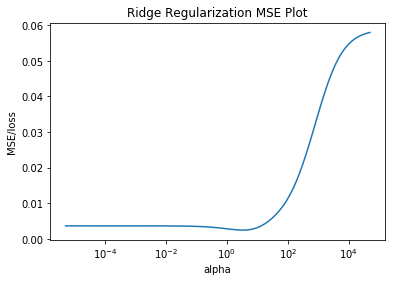

In [17]:
ax = plt.gca()
ax.plot(alphas, MSE_ridge)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('MSE/loss')
plt.title('Ridge Regularization MSE Plot')

In [18]:
# do cross validation to find alpha that gives the lowest MSE
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True, cv = 10)

In [19]:
ridgecv.fit(X_train, y_train)

RidgeCV(alphas=array([5.00000e+04, 3.96241e+04, ..., 6.30928e-06, 5.00000e-06]),
    cv=10, fit_intercept=True, gcv_mode=None, normalize=True,
    scoring='neg_mean_squared_error', store_cv_values=False)

In [20]:
ridgecv.alpha_

9.15369140147684

In [21]:
mean_squared_error(y_test, ridgecv.predict(X_test))

0.0030488149999117024

In [22]:
len(np.where(ridgecv.coef_!=0)[0])

4433

For ridge regularization, there is a slight decrease in the error rate after we increase alpha. However, the error starts to increase dramatically after it reaches its minimum. Using 10-fold cross validation, I found that the best alpha is 9.15 and its MSE (generalization error) is 0.003049. The number of features that have non-zero coefficients are 4433.

In [23]:
lasso = Lasso(max_iter = 10000, normalize = True)

In [24]:
MSE_lasso = []

In [25]:
for a in alphas:
    lasso.set_params(alpha = a)
    # normalize the data so that they are in the same scale
    lasso.fit(scale(X_train), y_train)
    pred = lasso.predict(X_test)
    MSE_lasso.append(mean_squared_error(y_test, pred))

Text(0.5, 1.0, 'Lasso Regularization MSE Plot')

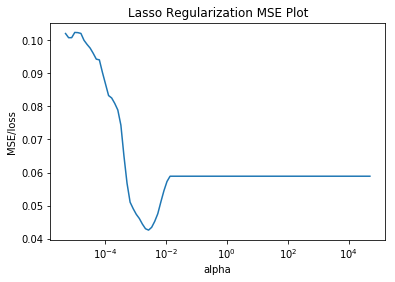

In [26]:
ax = plt.gca()
ax.plot(alphas, MSE_lasso)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('MSE/loss')
plt.title('Lasso Regularization MSE Plot')

In [27]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)

In [28]:
lassocv.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=100000, n_alphas=100, n_jobs=None, normalize=True,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [29]:
lassocv.alpha_

0.00017209783627258112

In [30]:
mean_squared_error(y_test, lassocv.predict(X_test))

0.01334436053763254

In [31]:
len(np.where(lassocv.coef_!=0)[0])

98

For lasso regularization, there is a significant decrease in MSE as I increase alpha. However, the MSE starts to increase back after it reaches its minimum and remains consistent after that. Using 10-fold cross validation, I found that the best alpha is 0.00017 and its MSE (generalization error) is 0.0133. The number of features that have non-zero coefficients are 98.

After comparing the results return from the lasso and ridge regularization, I have decided to use Lasso because it reduces much more features, which is more suitable in this case because our dataset is relatively small.

### Problem 2

Bootstrapping is a method that resample the data with replacement. 

Assumptions:
1) Each sample is randomly selected from the population and the selection is independent and unbiased
2) The sample distribution is a good approximation to the population distribution and the population is infinite

In [32]:
def bootstrap_predict(data_set, n_iterations, sample_size, test_case):
    # configure bootstrap
    # we use 10 bootstrap iterations and select a sample that is 50% the size of the dataset
    
    n_size = int(data_set.shape[0] * sample_size)
    
    values = data_set.loc[:, 'GrowthRate': 'pmrR'].values
    
    predict_list = list()
    
    for i in range(n_iterations):
        # prepare the train set and test set
        train = resample(values, n_samples = n_size)
        # if x is not in the trainset, then it is in the testset
        #test = np.array([x for x in values if x.tolist() not in train.tolist()])
        # use the lasso model
        model = lassocv
        # fit the model
        # check the index here
        model.fit(train[:, 1:], train[:, :1].ravel())
        # report the prediction
        prediction = model.predict(test_case)
        predict_list.append(prediction)
    
    # construct the 95% confidence interval
    alpha = 0.05
    p_lower = alpha/2.0 * 100
    lower = max(0.0, np.percentile(predict_list, p_lower))
    p_upper = (1 - (alpha)/2.0) * 100
    upper = min(1.0, np.percentile(predict_list, p_upper))
    
    print("The %.1f%% confidence interval of the prediction by using the bootstrapping method is %.4f and %.4f" %(((1-alpha)*100), lower, upper))


### Problem 3

In [33]:
gene_expression = data_set.loc[:, 'yhfA': 'pmrR']

In [34]:
# get the mean value
mean_gene = np.array(gene_expression.mean()).reshape(1, -1)

In [35]:
# The predicted growth for a bacterium whose genes are expressed exactly at the mean expression value is
bootstrap_predict(data_set, 10, 0.5, mean_gene)

The 95.0% confidence interval of the prediction by using the bootstrapping method is 0.3942 and 0.4351


### Problem 4

In [36]:
def create_matrix(feature_df, data_set, variable):
    """
    1) create matrices for features and target
    2) create train set and test set
    """
    cat_df = pd.concat([data_set.loc[:, : 'GrowthRate'], feature_df], axis = 1)
    X_cat = np.array(feature_df)
    pre_process = preprocessing.LabelEncoder()
    cat_df['num_' + variable] = pre_process.fit_transform(cat_df[variable])
    Y_cat = cat_df['num_' + variable].values.astype(np.float32)
    y_label_cat = label_binarize(Y_cat, classes = np.unique(Y_cat.astype(int)).tolist())
    X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X_cat, y_label_cat, test_size=0.3, random_state = 42)
    return X_cat, y_label_cat, X_cat_train, X_cat_test, y_cat_train, y_cat_test

In [37]:
def train_model(X_cat_train, y_cat_train):
    """
    find the optimal hyperparameters using cross validation
    """
    tuned_parameters = [{'estimator__kernel': ['rbf'], 'estimator__gamma': ['auto', 0.1], 'estimator__C': [1, 10, 100, 1000]},
                   {'estimator__kernel': ['poly'], 'estimator__gamma': ['auto', 0.1], 'estimator__C': [1, 10, 100, 1000]},
                   {'estimator__kernel': ['linear'], 'estimator__gamma': ['auto', 0.1], 'estimator__C': [1, 10, 100, 1000]}]
    
    # create a support vector machine model
    model_to_set = OneVsRestClassifier(SVC(probability=True))
    
    # scale the data
    X_cat_train = preprocessing.scale(X_cat_train)
    
    # we have 1 member in the y variable, data_set[data_set['Strain'] == 'BW25113'], therefore, it raises the warning message
    clf = GridSearchCV(model_to_set, tuned_parameters, cv = 10, iid = False)
    clf.fit(X_cat_train, y_cat_train)
    
    return clf

In [38]:
def graph(X_cat, Y_label_cat, variable, k_fold_num, graph_type, clf):
    
    """
    graph ROC and PR curve
    
    find the micro-average curve for each feature in each fold
    """
    
    rcParams['figure.figsize'] = 10, 10
    
    colors = cycle('bgrcmk')
    
    plt.figure()
    
    lw = 2
    
    # plot the false positive, true positive and area_under_curve value for each class on the graph
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    
    x_dict = dict()
    y_dict = dict()
    auc_dict = dict()
    
    k_fold = KFold(n_splits = k_fold_num, shuffle = True, random_state = 99)
    
    for i, (train_index, test_index) in enumerate(k_fold.split(X_cat)):
        # get the training and test set
        X_train, X_test = X_cat[train_index], X_cat[test_index]
        y_train, y_test = Y_label_cat[train_index], Y_label_cat[test_index]
        
        # preprocess the data
        X_train = preprocessing.scale(X_train)
        
        # fit the model
        y_score = clf.fit(X_train, y_train).decision_function(X_test)
        
        if graph_type == 'ROC':
            # Compute micro-average ROC curve and ROC area
            x_dict[i], y_dict[i], threshold = roc_curve(y_test.ravel(), y_score.ravel())
            auc_dict[i] = auc(x_dict[i], y_dict[i])
        else:
            # Compute micro-average PR curve and PR area
            x_dict[i], y_dict[i], threshold = precision_recall_curve(y_test.ravel(), y_score.ravel())
            auc_dict[i] = auc(y_dict[i], x_dict[i])
    
    if graph_type == 'ROC':
        plt.plot([0, 1], [0, 1], 'k--', lw = lw)
        
        for i, color in zip(range(k_fold_num), colors):
            plt.plot(x_dict[i], y_dict[i], color = color, lw = lw, label = 'ROC Curve of fold {0} (area = {1:0.2f})'.format(i, auc_dict[i]))
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend(loc = 'lower right')
    else:
        
        for i, color in zip(range(k_fold_num), colors):
            plt.plot(y_dict[i], x_dict[i], color = color, lw = lw, label = 'PR Curve of fold {0} (area = {1:0.2f})'.format(i, auc_dict[i]))
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.legend(loc = 'lower left')
    plt.title(graph_type + ' Curve for '+ variable + ' data')
    plt.show()

In [39]:
def svm_analyze(X_cat, Y_label_cat, var, k_fold_num, clf):
    graph(X_cat, Y_label_cat, var, k_fold_num, 'ROC', clf)
    graph(X_cat, Y_label_cat, var, k_fold_num, 'PR', clf)

In [40]:
var_list = ['Strain', 'Medium', 'Stress', 'GenePerturbed']
# Use the non-zero weighted features from the regularized regression technique
feature_df = data_set.iloc[:, np.where(lassocv.coef_!=0)[0]]

The number of features for all 4 classifiers are 98 because I used the non-zero weighted features from the lasso regularization as X.

The classifiers do a pretty good job in predicting GenePerturbed, followed by Stress and Strain. However, it does not perform too well for the Medium feature.

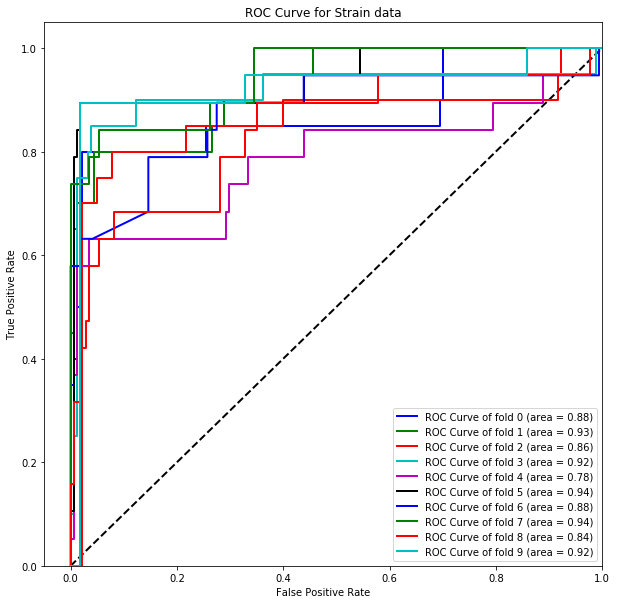

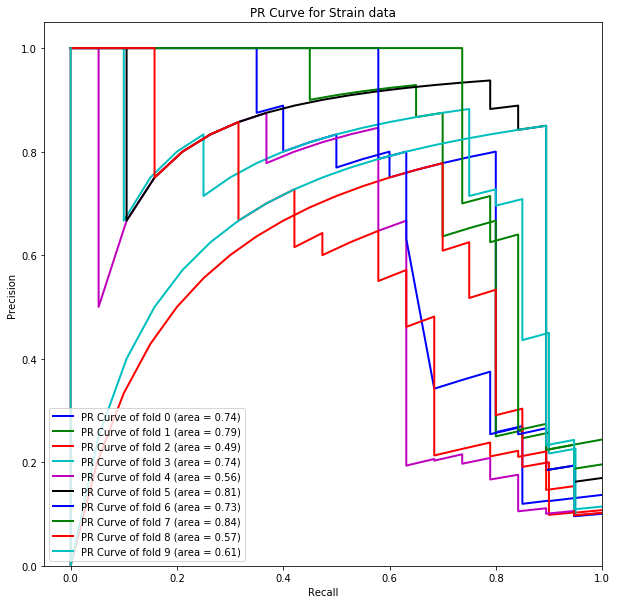

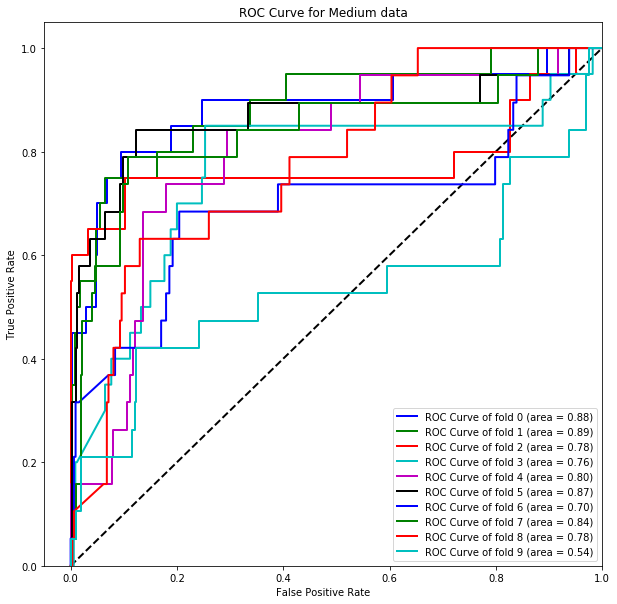

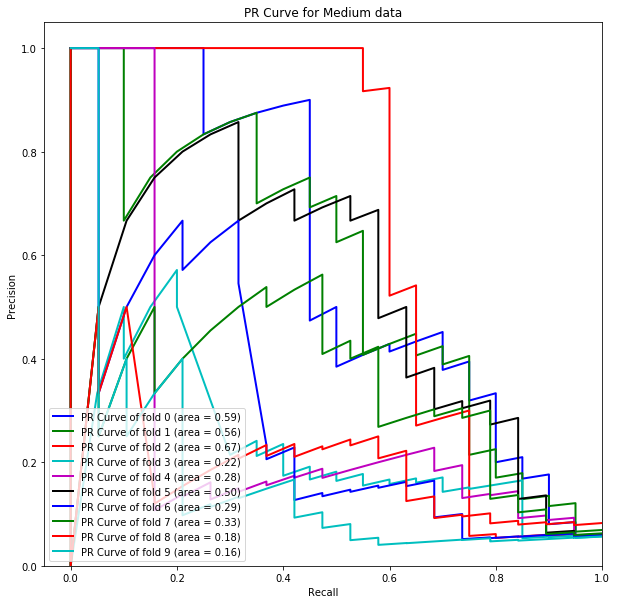

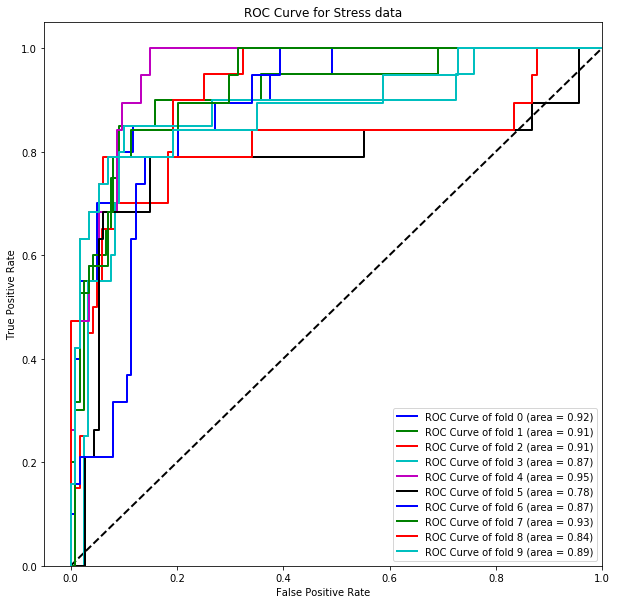

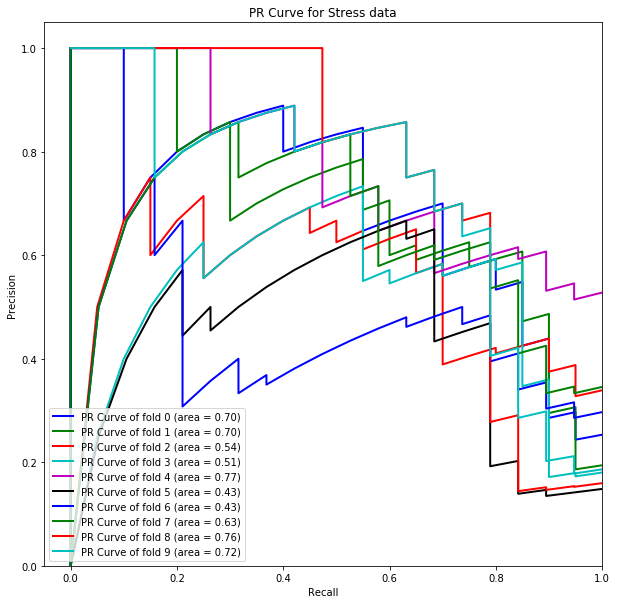

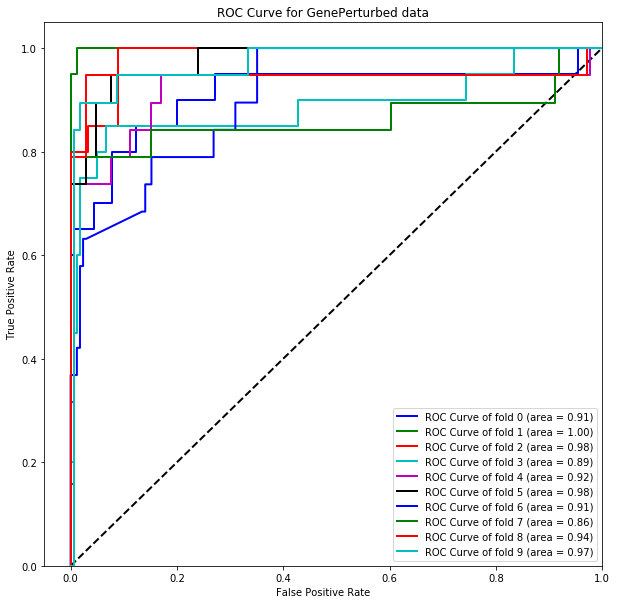

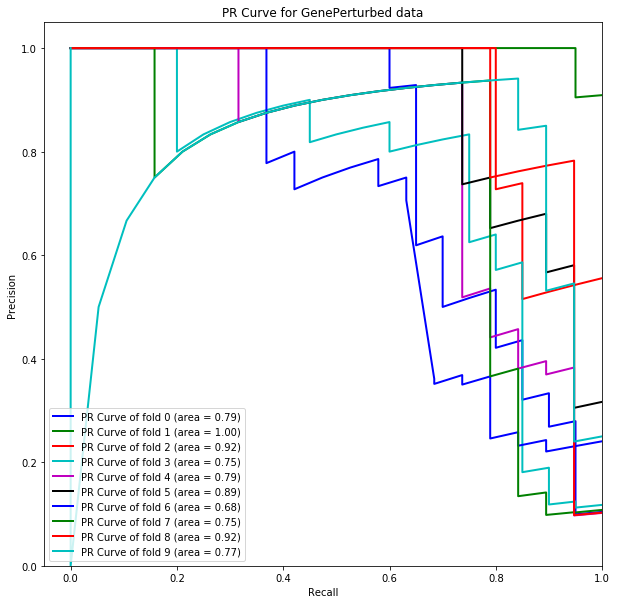

In [41]:
for var in var_list:
    X_cat, Y_label_cat, X_cat_train, X_cat_test, y_cat_train, y_cat_test= create_matrix(feature_df, data_set, var)
    clf = train_model(X_cat_train, y_cat_train)
    svm_analyze(X_cat, Y_label_cat, var, 10, clf)

### Problem 5

In [42]:
data_set['medium_stress'] = data_set['Medium'] + data_set['Stress']

In [43]:
cols = data_set.columns.tolist()

In [44]:
cols = cols[-1:] + cols[:-1]

In [45]:
data_set = data_set[cols]

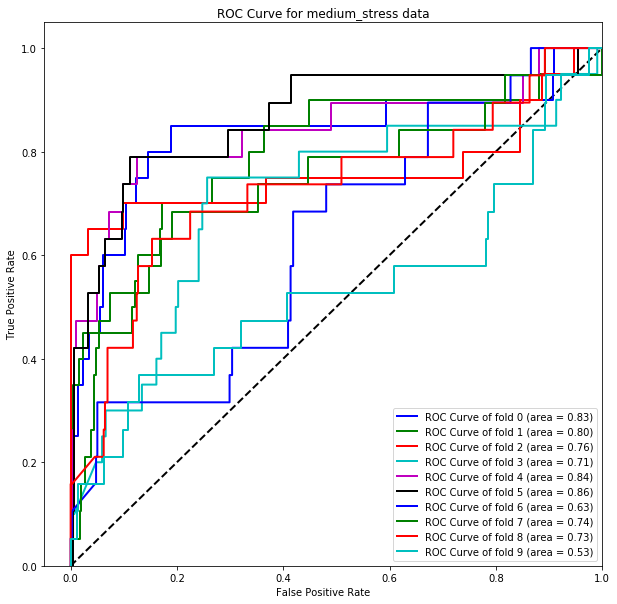

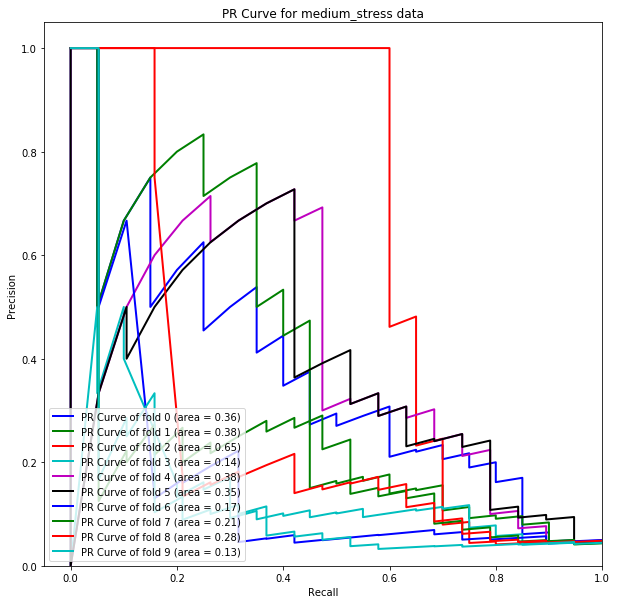

In [46]:
X_med, Y_label_med, X_med_train, X_med_test, y_med_train, y_med_test = create_matrix(feature_df, data_set, 'medium_stress')
clf = train_model(X_med_train, y_med_train)
svm_analyze(X_med, Y_label_med, 'medium_stress', 10, clf)

This classifier performs worse than the two individual classifiers together for these predictions. The null hypothesis is that the combined classifier performs better or equal to the two individual classifiers. Our result proves that our null hypothesis is incorrect.

### Problem 6

In [47]:
X = np.array(data_set.loc[:, 'yhfA': 'pmrR'])
# get the first three principal components and store them in a dataframe
pca = PCA(n_components = 3)
prin_components = pca.fit_transform(X)
prin_df = pd.DataFrame(prin_components, columns = ['Principal_Component_1', 'Principal_Component_2', 'Principal_Component_3'])
prin_df = prin_df.reset_index(drop = True)


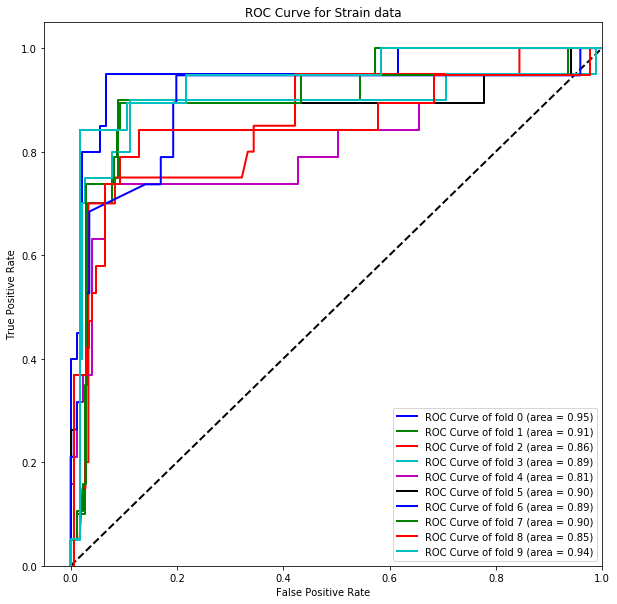

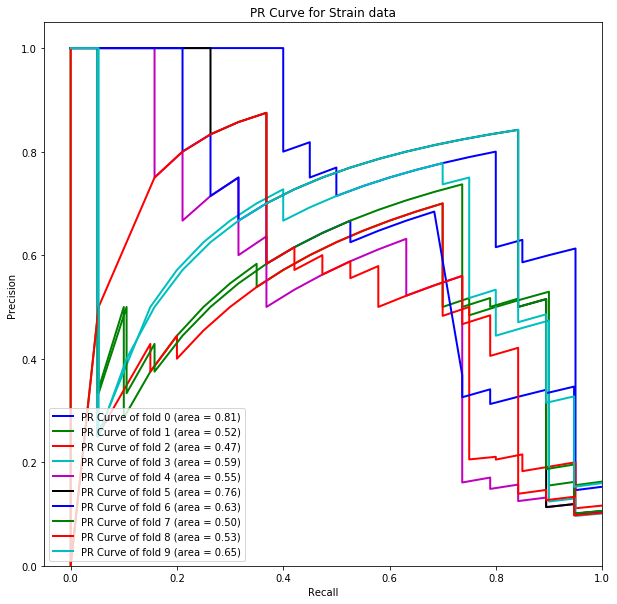

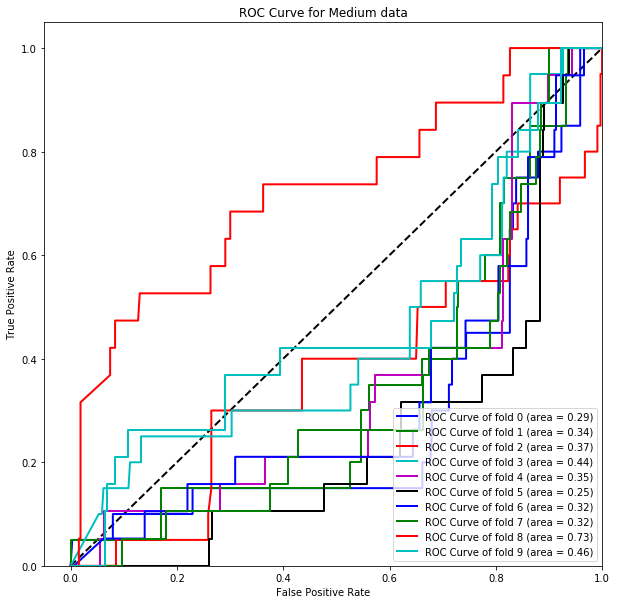

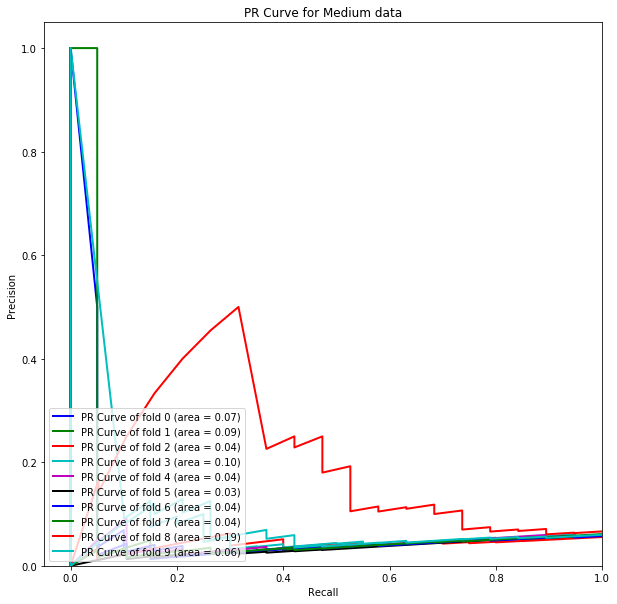

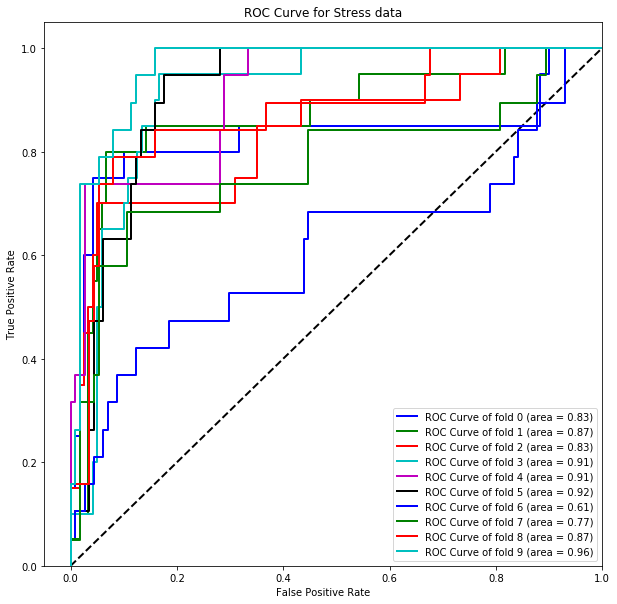

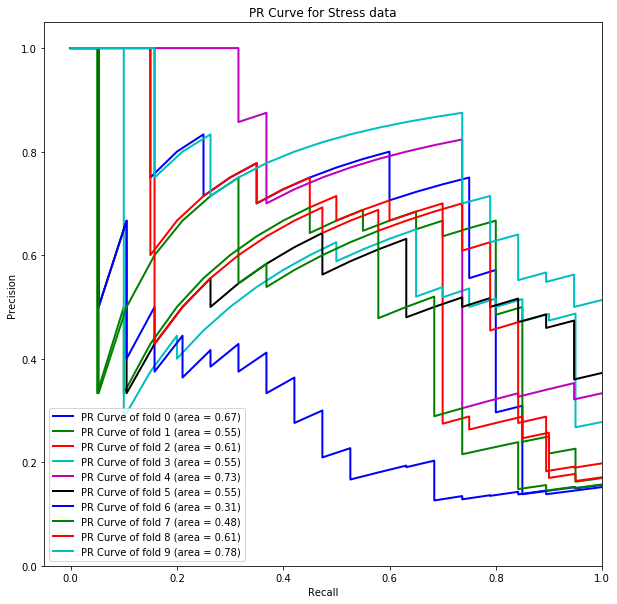

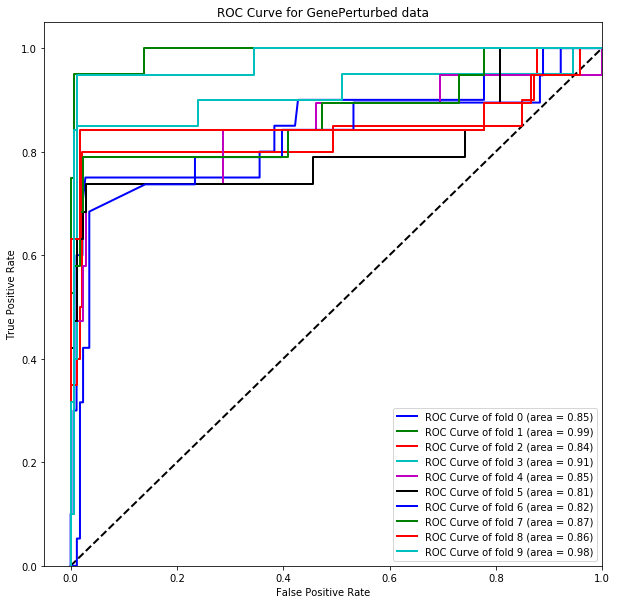

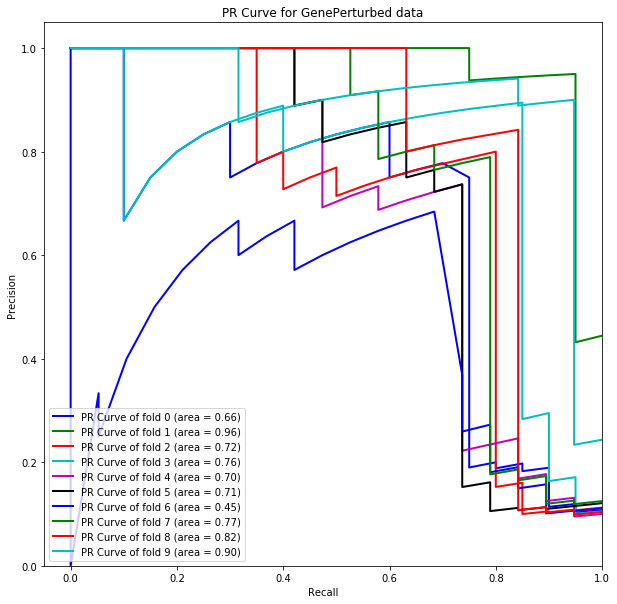

In [48]:
for var in var_list:
    X_cat_prin, Y_label_cat_prin, X_cat_train_prin, X_cat_test_prin, y_cat_train_prin, y_cat_test_prin = create_matrix(prin_df, data_set, var)
    clf = train_model(X_cat_train_prin, y_cat_train_prin)
    svm_analyze(X_cat_prin, Y_label_cat_prin, var, 10, clf)

The PCs retain most of the classification performance while reducing the
dimensionality because AUC/AUPRC value for Strain, Stress and GenePerturbed are still relatively high given we only have three principal components. However, AUC/AUPRC value for Medium drops significantly. 